## Let's get started!

Same as before, first install the `openai` library with `pip`.



In [ ]:
!pip install openai

The following cell will import the appropriate parts of the `openai` library, along with another library called `getpass` that will ask for the API key and store it for future use in this notebook session. It also sets a few other environment variables.

In [ ]:
import getpass
from openai import AzureOpenAI

AZURE_ENDPOINT = "https://cail-training-canadaeast.openai.azure.com/"
AZURE_API_KEY = getpass.getpass(prompt='Enter AzureOpenAI API key:')
AZURE_MODEL_KEY = "gpt432k"
AZURE_API_VERSION = "2024-03-01-preview"


Now we call the AzureOpenAI constructor to create a new instance of the client that we'll use for the rest of the notebook.

In [ ]:
client = AzureOpenAI(
    azure_endpoint=AZURE_ENDPOINT,
    api_key=AZURE_API_KEY,
    api_version=AZURE_API_VERSION
)

But wait! We need some data for this one! Conveniently, I've created six examples that we can work with. The following lines will import the data as a `jsonl` file.

A `jsonl` file contains a JSON object on each line. Every JSON object is formatted as follows:

```
{
  "sentence": # the sentence to incorporate into the prompt
  "rest": # the next couple of sentences to serve as our control
  "gender": # the gender of the subject of the sentence,
            # according to LK who has read all of the books
  "author": # the author of the book, just for reference
  "title":  # the title of the book, same
}
```

Now that we know what our data will look like, let's download it and take an actual look:

In [ ]:
# here's some code to download our data from github

!wget https://raw.githubusercontent.com/laurenfklein/QTM340-Fall24/main/corpora/books.jsonl

In [ ]:
# a library we'll need for manipulating json

import json

In [ ]:
# Read the sentence data from file and store them as a list
def read_data_from_file (filename):
  data = list ()
  with open (filename) as fin:
    for line in fin:
      js = json.loads (line)
      data.append (js)
  return data

books = read_data_from_file ("books.jsonl")

# and just to check
len(books)

In [ ]:
# take a look at the first one
books[0]

### And off we go!

Here is the prompt that we're going to use:

In [ ]:
zero_shot_prompt_template = "Complete a short story that begins with the line: "

As in our previous class, let's define a function that takes the template and an example and merges them into a prompt:

In [ ]:
def construct_no_shot_prompt (prompt_template, line):
  full_prompt = prompt_template + "\"" + line + "\""
  return full_prompt

In [ ]:
# check to see whether it works

prompt = construct_no_shot_prompt(zero_shot_prompt_template, books[0]["sentence"])

prompt

So this looks good to go. But in order to set up our actual query, we need to return to the paper for some more details. For reference, here is the "Data" section of the paper again:

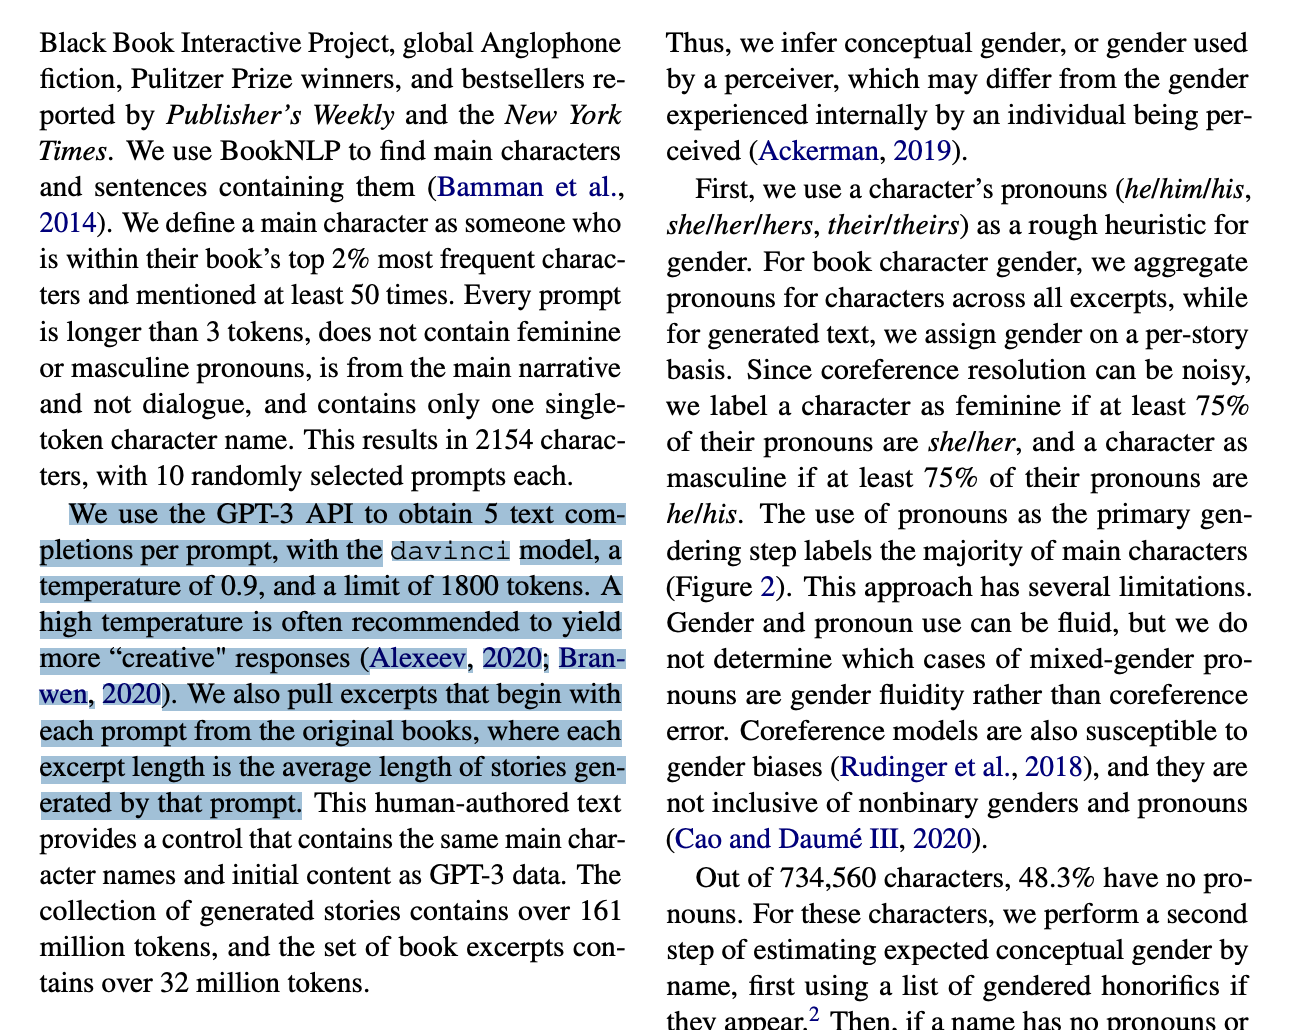

So it looks like we have all the information that we need to set up our query.

## Your turn!

*   What was the maximum number of tokens that Lucy used in her paper?
*   What did she use as temperature?
*   How many responses ("completions") did she request?

Once you've found these numbers in the paper, add them into the query function below.

In [ ]:
def lucy_query_chatGPT (prompt):
  response = client.chat.completions.create( # Use the chat completions endpoint
    model=AZURE_MODEL_KEY,
    messages=[
      {"role": "user", "content": prompt}, # Use messages parameter for chat models
    ],
    max_tokens=    ,  # look up above for the max tokens
    temperature=   ,  # look up above for temperature
    n=                # same for number of completions
  )

  # create a list to store the responses
  responses = []

  # iterate over the choices to pull out the text from each
  # and append to our responses list
  for choice in response.choices:
    responses.append(choice.message.content)

  # return the list
  return(responses)




For the purposes of this exercise, we're going to use a lower number of max tokens for resource / cost conservation. Here is a slightly modified version of the function above that we can use.

In [ ]:
def query_chatGPT (prompt):
  response = client.chat.completions.create( # Use the chat completions endpoint
    model=AZURE_MODEL_KEY,
    messages=[
      {"role": "user", "content": prompt}, # Use messages parameter for chat models
    ],
    max_tokens= 200,
    temperature=.9,
    n=5
  )

  # create a list to store the responses
  responses = []

  # iterate over the choices to pull out the text from each
  # and append to our responses list
  for choice in response.choices:
    responses.append(choice.message.content)

  # return the list
  return(responses)


Let's try it out with only the first example, which is another good best practice: before you run anything time-intensive and costly, make sure that it works!

In [ ]:
# for nicely formatted printing
import textwrap

# here's our prompt
prompt = construct_no_shot_prompt(zero_shot_prompt_template, books[0]["sentence"])

# and where we'll make the query call
responses = query_chatGPT(prompt)

# and now let's run it!
for i, response in enumerate(responses):
  print("Response " + str(i) + ": " )
  print(textwrap.fill(response, 100))


So that is working! Let's now use our query function to get responses for all of the examples.

In [ ]:
for book in books:
  prompt = construct_no_shot_prompt(zero_shot_prompt_template, book["sentence"])
  responses = query_chatGPT(prompt)

  # add the responses to our json for future examination
  book["responses"] = responses


In [ ]:
# take a look at the first one
books[0]

Looks good! Now let's download our json file for future use.

In [ ]:
from google.colab import files

books_json = json.dumps(books, indent=4)

with open('books-with-responses.json', 'w') as f:
  f.write(books_json)

files.download('books-with-responses.json')


*I wrote version 1.0 of this notebook in Fall 2024 thanks to OpenAI API access provided by Joe Sutherland at Emory's [CAIL](https://ailearning.emory.edu/) and materials synthesized from the AI for Humanists [Zero-Shot Prompting tutorial](https://aiforhumanists.com/tutorials/) and Sandeep Soni's [previous QTM 340 course materials](https://github.com/sandeepsoni/QTM340) with additional suggestions from the inimitable Lucy Li.*